In [1]:

# Run some setup code for this notebook.

import random
import numpy as np
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [5]:
import kagglehub
path = kagglehub.dataset_download("janzenliu/cifar-10-batches-py")

print("Path to dataset files:", path)

100%|██████████| 162M/162M [00:02<00:00, 76.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/janzenliu/cifar-10-batches-py/versions/1


In [2]:
from __future__ import print_function

from builtins import range
from six.moves import cPickle as pickle
import numpy as np
import os
from imageio import imread
import platform


def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == "2":
        return pickle.load(f)
    elif version[0] == "3":
        return pickle.load(f, encoding="latin1")
    raise ValueError("invalid python version: {}".format(version))


def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, "rb") as f:
        datadict = load_pickle(f)
        X = datadict["data"]
        Y = datadict["labels"]
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X, Y


def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(ROOT, "data_batch_%d" % (b,))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, "test_batch"))
    return Xtr, Ytr, Xte, Yte


def get_CIFAR10_data(
    num_training=49000, num_validation=1000, num_test=1000, subtract_mean=True
):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for classifiers. These are the same steps as we used for the SVM, but
    condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = os.path.join(
        os.path.dirname(__file__), "datasets/cifar-10-batches-py"
    )
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    if subtract_mean:
        mean_image = np.mean(X_train, axis=0)
        X_train -= mean_image
        X_val -= mean_image
        X_test -= mean_image

    # Transpose so that channels come first
    X_train = X_train.transpose(0, 3, 1, 2).copy()
    X_val = X_val.transpose(0, 3, 1, 2).copy()
    X_test = X_test.transpose(0, 3, 1, 2).copy()

    # Package data into a dictionary
    return {
        "X_train": X_train,
        "y_train": y_train,
        "X_val": X_val,
        "y_val": y_val,
        "X_test": X_test,
        "y_test": y_test,
    }


def load_tiny_imagenet(path, dtype=np.float32, subtract_mean=True):
    """
    Load TinyImageNet. Each of TinyImageNet-100-A, TinyImageNet-100-B, and
    TinyImageNet-200 have the same directory structure, so this can be used
    to load any of them.

    Inputs:
    - path: String giving path to the directory to load.
    - dtype: numpy datatype used to load the data.
    - subtract_mean: Whether to subtract the mean training image.

    Returns: A dictionary with the following entries:
    - class_names: A list where class_names[i] is a list of strings giving the
      WordNet names for class i in the loaded dataset.
    - X_train: (N_tr, 3, 64, 64) array of training images
    - y_train: (N_tr,) array of training labels
    - X_val: (N_val, 3, 64, 64) array of validation images
    - y_val: (N_val,) array of validation labels
    - X_test: (N_test, 3, 64, 64) array of testing images.
    - y_test: (N_test,) array of test labels; if test labels are not available
      (such as in student code) then y_test will be None.
    - mean_image: (3, 64, 64) array giving mean training image
    """
    # First load wnids
    with open(os.path.join(path, "wnids.txt"), "r") as f:
        wnids = [x.strip() for x in f]

    # Map wnids to integer labels
    wnid_to_label = {wnid: i for i, wnid in enumerate(wnids)}

    # Use words.txt to get names for each class
    with open(os.path.join(path, "words.txt"), "r") as f:
        wnid_to_words = dict(line.split("\t") for line in f)
        for wnid, words in wnid_to_words.items():
            wnid_to_words[wnid] = [w.strip() for w in words.split(",")]
    class_names = [wnid_to_words[wnid] for wnid in wnids]

    # Next load training data.
    X_train = []
    y_train = []
    for i, wnid in enumerate(wnids):
        if (i + 1) % 20 == 0:
            print("loading training data for synset %d / %d" % (i + 1, len(wnids)))
        # To figure out the filenames we need to open the boxes file
        boxes_file = os.path.join(path, "train", wnid, "%s_boxes.txt" % wnid)
        with open(boxes_file, "r") as f:
            filenames = [x.split("\t")[0] for x in f]
        num_images = len(filenames)

        X_train_block = np.zeros((num_images, 3, 64, 64), dtype=dtype)
        y_train_block = wnid_to_label[wnid] * np.ones(num_images, dtype=np.int64)
        for j, img_file in enumerate(filenames):
            img_file = os.path.join(path, "train", wnid, "images", img_file)
            img = imread(img_file)
            if img.ndim == 2:
                ## grayscale file
                img.shape = (64, 64, 1)
            X_train_block[j] = img.transpose(2, 0, 1)
        X_train.append(X_train_block)
        y_train.append(y_train_block)

    # We need to concatenate all training data
    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)

    # Next load validation data
    with open(os.path.join(path, "val", "val_annotations.txt"), "r") as f:
        img_files = []
        val_wnids = []
        for line in f:
            img_file, wnid = line.split("\t")[:2]
            img_files.append(img_file)
            val_wnids.append(wnid)
        num_val = len(img_files)
        y_val = np.array([wnid_to_label[wnid] for wnid in val_wnids])
        X_val = np.zeros((num_val, 3, 64, 64), dtype=dtype)
        for i, img_file in enumerate(img_files):
            img_file = os.path.join(path, "val", "images", img_file)
            img = imread(img_file)
            if img.ndim == 2:
                img.shape = (64, 64, 1)
            X_val[i] = img.transpose(2, 0, 1)

    # Next load test images
    # Students won't have test labels, so we need to iterate over files in the
    # images directory.
    img_files = os.listdir(os.path.join(path, "test", "images"))
    X_test = np.zeros((len(img_files), 3, 64, 64), dtype=dtype)
    for i, img_file in enumerate(img_files):
        img_file = os.path.join(path, "test", "images", img_file)
        img = imread(img_file)
        if img.ndim == 2:
            img.shape = (64, 64, 1)
        X_test[i] = img.transpose(2, 0, 1)

    y_test = None
    y_test_file = os.path.join(path, "test", "test_annotations.txt")
    if os.path.isfile(y_test_file):
        with open(y_test_file, "r") as f:
            img_file_to_wnid = {}
            for line in f:
                line = line.split("\t")
                img_file_to_wnid[line[0]] = line[1]
        y_test = [wnid_to_label[img_file_to_wnid[img_file]] for img_file in img_files]
        y_test = np.array(y_test)

    mean_image = X_train.mean(axis=0)
    if subtract_mean:
        X_train -= mean_image[None]
        X_val -= mean_image[None]
        X_test -= mean_image[None]

    return {
        "class_names": class_names,
        "X_train": X_train,
        "y_train": y_train,
        "X_val": X_val,
        "y_val": y_val,
        "X_test": X_test,
        "y_test": y_test,
        "class_names": class_names,
        "mean_image": mean_image,
    }


def load_models(models_dir):
    """
    Load saved models from disk. This will attempt to unpickle all files in a
    directory; any files that give errors on unpickling (such as README.txt)
    will be skipped.

    Inputs:
    - models_dir: String giving the path to a directory containing model files.
      Each model file is a pickled dictionary with a 'model' field.

    Returns:
    A dictionary mapping model file names to models.
    """
    models = {}
    for model_file in os.listdir(models_dir):
        with open(os.path.join(models_dir, model_file), "rb") as f:
            try:
                models[model_file] = load_pickle(f)["model"]
            except pickle.UnpicklingError:
                continue
    return models


def load_imagenet_val(num=None):
    """Load a handful of validation images from ImageNet.

    Inputs:
    - num: Number of images to load (max of 25)

    Returns:
    - X: numpy array with shape [num, 224, 224, 3]
    - y: numpy array of integer image labels, shape [num]
    - class_names: dict mapping integer label to class name
    """
    imagenet_fn = os.path.join(
        os.path.dirname(__file__), "datasets/imagenet_val_25.npz"
    )
    if not os.path.isfile(imagenet_fn):
        print("file %s not found" % imagenet_fn)
        print("Run the following:")
        print("cd cs231n/datasets")
        print("bash get_imagenet_val.sh")
        assert False, "Need to download imagenet_val_25.npz"

    # modify the default parameters of np.load
    # https://stackoverflow.com/questions/55890813/how-to-fix-object-arrays-cannot-be-loaded-when-allow-pickle-false-for-imdb-loa
    np_load_old = np.load
    np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
    f = np.load(imagenet_fn)
    np.load = np_load_old
    X = f["X"]
    y = f["y"]
    class_names = f["label_map"].item()
    if num is not None:
        X = X[:num]
        y = y[:num]
    return X, y, class_names


In [6]:
cifar10_dir = path

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


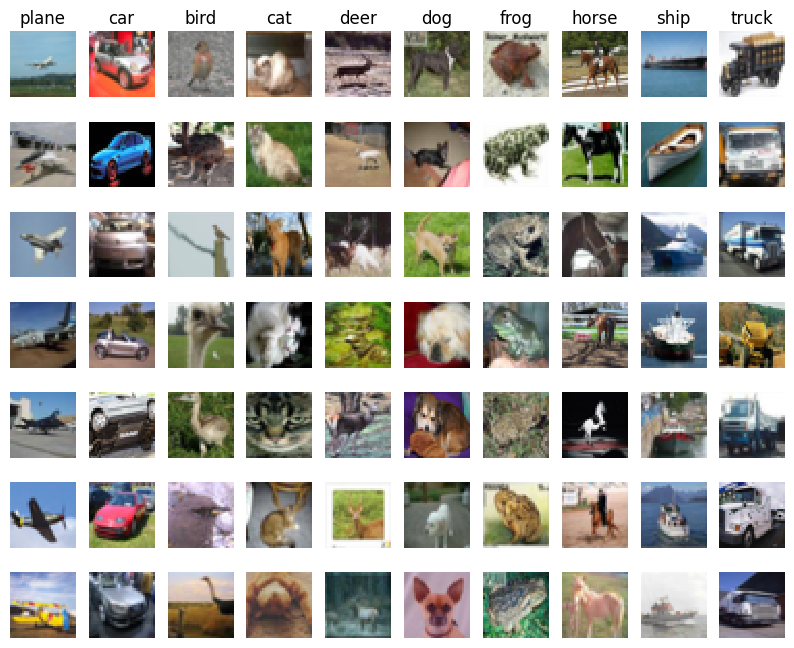

In [7]:

# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [8]:
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [9]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [71]:
from builtins import range
from builtins import object
import numpy as np
from past.builtins import xrange


class KNearestNeighbor(object):
    """ a kNN classifier with L2 distance """

    def __init__(self):
        pass

    def train(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X, k=1, num_loops=0):
        """
        Predict labels for test data using this classifier.

        Inputs:
        - X: A numpy array of shape (num_test, D) containing test data consisting
             of num_test samples each of dimension D.
        - k: The number of nearest neighbors that vote for the predicted labels.
        - num_loops: Determines which implementation to use to compute distances
          between training points and testing points.

        Returns:
        - y: A numpy array of shape (num_test,) containing predicted labels for the
          test data, where y[i] is the predicted label for the test point X[i].
        """
        if num_loops == 0:
            dists = self.compute_distances_no_loops(X)
        elif num_loops == 1:
            dists = self.compute_distances_one_loop(X)
        elif num_loops == 2:
            dists = self.compute_distances_two_loops(X)
        else:
            raise ValueError("Invalid value %d for num_loops" % num_loops)

        return self.predict_labels(dists, k=k)

    def compute_distances_two_loops(self, X):
        """
        Compute the distance between each test point in X and each training point
        in self.X_train using a nested loop over both the training data and the
        test data.

        Inputs:
        - X: A numpy array of shape (num_test, D) containing test data.

        Returns:
        - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
          is the Euclidean distance between the ith test point and the jth training
          point.
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        for i in range(num_test):
            for j in range(num_train):
                #####################################################################
                # TODO:                                                             #
                # Compute the l2 distance between the ith test point and the jth    #
                # training point, and store the result in dists[i, j]. You should   #
                # not use a loop over dimension, nor use np.linalg.norm().          #
                #####################################################################
                # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
                dists[i,j] = np.sqrt(np.sum(np.square(X[i, :] - self.X_train[j, :])))
                # pass

                # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return dists

    def compute_distances_one_loop(self, X):
        """
        Compute the distance between each test point in X and each training point
        in self.X_train using a single loop over the test data.

        Input / Output: Same as compute_distances_two_loops
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        for i in range(num_test):
            #######################################################################
            # TODO:                                                               #
            # Compute the l2 distance between the ith test point and all training #
            # points, and store the result in dists[i, :].                        #
            # Do not use np.linalg.norm().                                        #
            #######################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            dists[i, :] = np.sqrt (np.sum (np.square (X[i, :]- self.X_train), axis =1))

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return dists

    def compute_distances_no_loops(self, X):
        """
        Compute the distance between each test point in X and each training point
        in self.X_train using no explicit loops.

        Input / Output: Same as compute_distances_two_loops
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        #########################################################################
        # TODO:                                                                 #
        # Compute the l2 distance between all test points and all training      #
        # points without using any explicit loops, and store the result in      #
        # dists.                                                                #
        #                                                                       #
        # You should implement this function using only basic array operations; #
        # in particular you should not use functions from scipy,                #
        # nor use np.linalg.norm().                                             #
        #                                                                       #
        # HINT: Try to formulate the l2 distance using matrix multiplication    #
        #       and two broadcast sums.                                         #
        #########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)****

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        dists = np.sqrt(
          -2 * (X @ self.X_train.T) +
          np.power(X, 2).sum(axis=1, keepdims=True) +
          np.power(self.X_train, 2).sum(axis=1, keepdims=True).T
        )
        return dists

    def predict_labels(self, dists, k=1):
        """
        Given a matrix of distances between test points and training points,
        predict a label for each test point.

        Inputs:
        - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
          gives the distance betwen the ith test point and the jth training point.

        Returns:
        - y: A numpy array of shape (num_test,) containing predicted labels for the
          test data, where y[i] is the predicted label for the test point X[i].
        """
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            # A list of length k storing the labels of the k nearest neighbors to
            # the ith test point.
            closest_y = []
            #########################################################################
            # TODO:                                                                 #
            # Use the distance matrix to find the k nearest neighbors of the ith    #
            # testing point, and use self.y_train to find the labels of these       #
            # neighbors. Store these labels in closest_y.                           #
            # Hint: Look up the function numpy.argsort.                             #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            # sắp xếp sort từ dist bé nhất tới dist lớn nhất theo index
            temp = dists[i].argsort ()
            # lấy index sort trong tập train
            tempTrain = self.y_train [temp[:k]]
            closest_y = tempTrain


            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            #########################################################################
            # TODO:                                                                 #
            # Now that you have found the labels of the k nearest neighbors, you    #
            # need to find the most common label in the list closest_y of labels.   #
            # Store this label in y_pred[i]. Break ties by choosing the smaller     #
            # label.                                                                #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            y_pred[i] = np.argmax(np.bincount(closest_y))


            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        return y_pred


In [72]:
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

In [66]:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


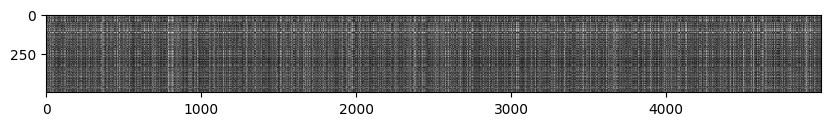

In [63]:
plt.imshow(dists, interpolation='none')
plt.show()


Notice the structured patterns in the distance matrix, where some rows or columns are visibly brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?
Row: text sample, column : train sample
(i,j) -> dist between test i and train j
white -> low similarity
black -> high similarity

-> bright row: test image far from train image
-> bright column: train image far from test image

In [67]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


In [68]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


In [69]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('One loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

One loop difference was: 0.000000
Good! The distance matrices are the same


In [73]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('No loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

No loop difference was: 0.000000
Good! The distance matrices are the same


In [74]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# You should see significantly faster performance with the fully vectorized implementation!

# NOTE: depending on what machine you're using,
# you might not see a speedup when you go from two loops to one loop,
# and might even see a slow-down.

Two loop version took 37.094794 seconds
One loop version took 54.090670 seconds
No loop version took 1.033750 seconds


In [76]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

X_train_fold = np.array_split (X_train, num_folds)
y_train_fold = np.array_split (y_train, num_folds)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for k in k_choices:
    k_to_accuracies[k] = []

    for i in range (num_folds):
      X_train_temp = np.concatenate (np.compress (np.arange (num_folds)!= i, X_train_fold, axis =0))
      y_train_temp = np.concatenate (np.compress (np.arange (num_folds)!= i, y_train_fold, axis =0))
      classifier.train (X_train_temp, y_train_temp)
      y_predic = classifier.predict (X_train_fold[i], k = k, num_loops=0)
      num_cor = np.sum (y_predic == y_train_fold[i])
      k_to_accuracies[k].append (num_cor/ len (y_predic))

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.252000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 15, accuracy = 0.282000
k = 15, accuracy = 0.274000
k = 20, accuracy = 0.270000
k = 20, accu

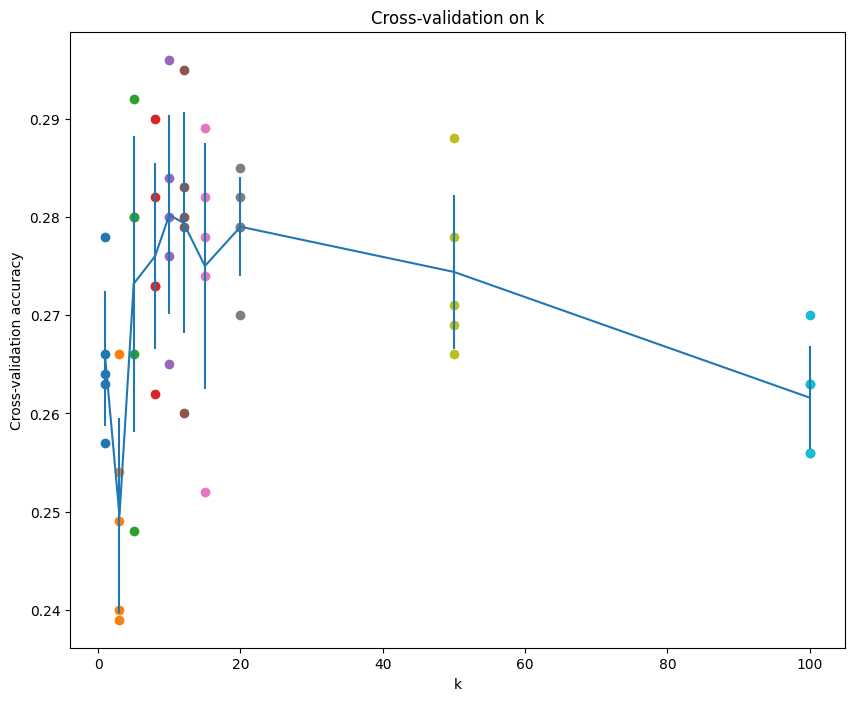

In [77]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [78]:
# Based on the cross-validation results above, choose the best value for k,
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 1

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000
